# Stable Diffusion Lora Training using HuggingFace

LoRA `(Low-Rank Adaptation of Large Language Models)` is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share. LoRA can also be combined with other training techniques like DreamBooth to speedup training.

Reference: https://huggingface.co/docs/diffusers/en/training/lora

### Check that your GPU is available

In [ ]:
! nvidia-smi

Sun Mar 31 18:30:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install Diffusers library and other requirements


In [ ]:
! pip install peft xformers bitsandbytes transformers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

Make sure to install `diffusers` from `main`.

In [ ]:
! pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download `diffusers` dreambooth LoRa training script.

In [ ]:
! wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

--2024-03-31 18:33:23--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57294 (56K) [text/plain]
Saving to: ‘train_dreambooth_lora.py’

train_dreambooth_lo 100%[===================>]  55.95K  --.-KB/s    in 0.006s  

2024-03-31 18:33:24 (8.47 MB/s) - ‘train_dreambooth_lora.py’ saved [57294/57294]



## Dataset 🧑

In [ ]:
DATASET_FOLDER_NAME = "Folder"  # Complete with your own dataset folder name

Preview your images:

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

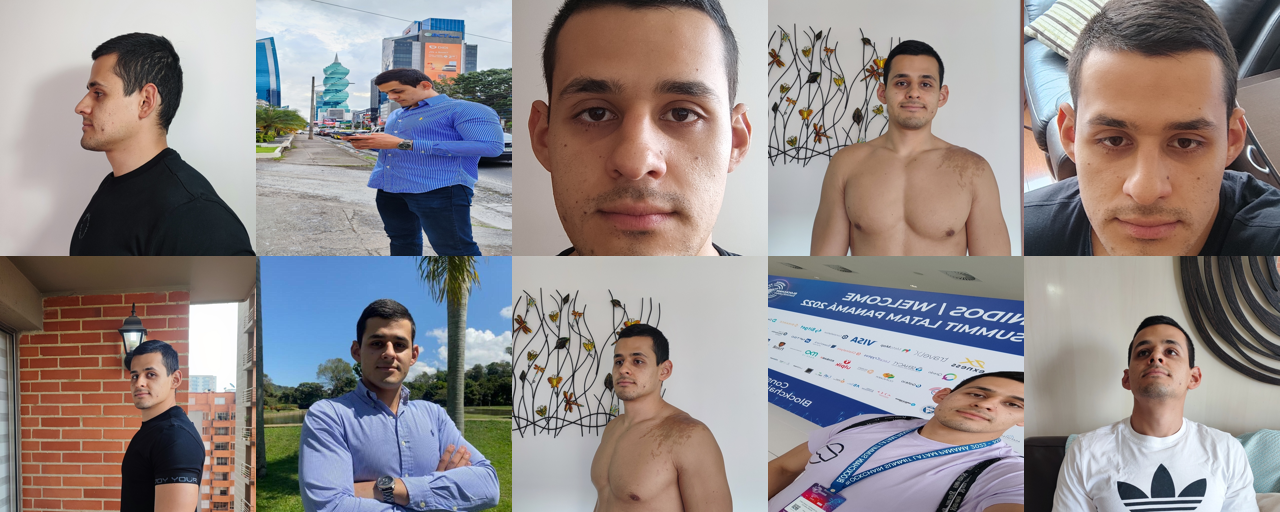

In [ ]:
import glob

imgs = [Image.open(path) for path in glob.glob(f"./{DATASET_FOLDER_NAME}/*.jpg")][:10]
imgs
image_grid(imgs, 2, 5)

## Prep for training 💻

In [ ]:
! accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


## Imports

In [ ]:
from diffusers import AutoPipelineForText2Image
from diffusers import EulerAncestralDiscreteScheduler
import torch

import warnings
warnings.filterwarnings('ignore')

## Training Dreambooth Lora
https://huggingface.co/docs/peft/en/task_guides/dreambooth_lora

Review all the parameters!! specially:
- `--instance_data_dir`: The directory containing the images that you intend to use for training your model.
- `--output_dir`: The destination folder for storing the trained model’s weights.
- `--pretrained_model_name_or_path`: The SD version you want to re-train
- `--learning_rate` and `--max_train_steps`: these parameter can affect the results

### Run training

If you are running this script on Windows, you may need to set the --num_dataloader_workers to 0.

In [ ]:
! accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="Folder" \
  --output_dir="models/my_lora/" \
  --instance_prompt="a photo of LASR person" \
  --resolution=1024 \
  --max_train_steps=1000 \
  --checkpointing_steps=300 \
  --mixed_precision="fp16" \
  --dataloader_num_workers=8 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --lr_warmup=0 \
  --num_train_epochs=1 \
  --seed=1234 \
  --use_8bit_adam \
  --train_text_encoder

2024-03-29 14:41:37.154149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 14:41:37.154205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 14:41:37.155587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 14:41:38.343691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
03/29/2024 14:41:39 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of ty

Once training has been completed, you can use your model for inference:

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights("models/my_lora/", weight_name="pytorch_lora_weights.safetensors")
#pipeline.scheduler=EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-1.5", subfolder="scheduler")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

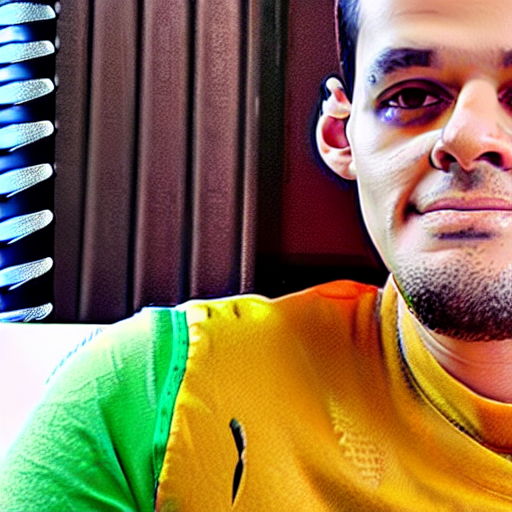

In [ ]:
image = pipeline("photo of LASR").images[0]
image

In [ ]:
image = pipeline("LASR person, in a war, by greg rutkowsky", guidance_scale=7, num_inference_steps=10).images[0]
image.show()

  0%|          | 0/10 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/80 [00:00<?, ?it/s]

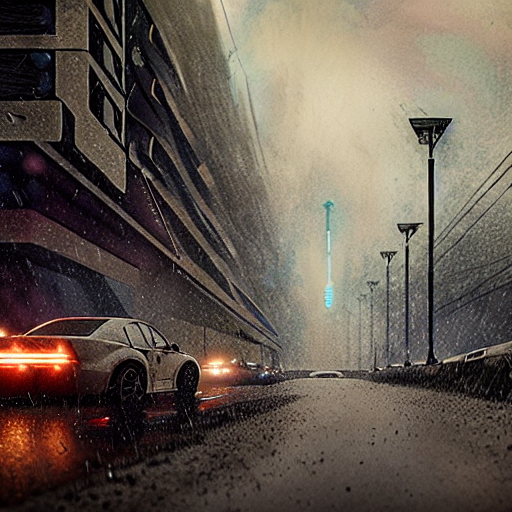

In [ ]:
image = pipeline("a photograph of LASR in Postapocalyptic combat scene, Ammo Boxes, Rain, Stormy, Wet, abstract beauty, near perfection, pure form, intricate detail, 8k post-production, High resolution, super Detail, trending on ArtStation, sharp focus, studio photos, intricate detail, Very detailed, By Greg Rutkowski", guidance_scale=10, num_inference_steps=80).images[0]
image

### With Prior Preservation

This technique helps the model by giving it more context as to what the new concept is. For example, if you are training with a person's face, it helps to accompany your photos with images of what the model understands to be a "person"

To do that, download all "person" images from https://github.com/aitrepreneur/REGULARIZATION-IMAGES-SD

In [ ]:
! git clone https://github.com/aitrepreneur/REGULARIZATION-IMAGES-SD.git

Cloning into 'REGULARIZATION-IMAGES-SD'...
remote: Enumerating objects: 1504, done.
remote: Total 1504 (delta 0), reused 0 (delta 0), pack-reused 1504
Receiving objects: 100% (1504/1504), 657.41 MiB | 41.64 MiB/s, done.
Updating files: 100% (1501/1501), done.


Then, we can add the parameters:
```--with_prior_preservation \
  --num_class_images=50 \
  --class_data_dir="REGULARIZATION-IMAGES-SD/person" \
  --class_prompt="photo of a person"
```

Please note that if you do not use these downloaded images and run the code, the algorithm will generate "person" images automatically. But it usually works better just with these that the user `aitrepreneu` adjusted for you.

In [ ]:
! accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="Folder" \
  --output_dir="models/my_lora_prior/" \
  --instance_prompt="a photo of LASR person" \
  --resolution=512 \
  --max_train_steps=300 \
  --checkpointing_steps=300 \
  --mixed_precision="fp16" \
  --dataloader_num_workers=8 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --lr_warmup=0 \
  --num_train_epochs=1 \
  --seed=1234 \
  --prior_loss_weight=1.0 \
  --use_8bit_adam \
  --train_text_encoder \
  --with_prior_preservation \
  --num_class_images=50 \
  --class_data_dir="REGULARIZATION-IMAGES-SD/person" \
  --class_prompt="photo of a person"

2024-03-29 17:16:16.699198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 17:16:16.699347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 17:16:16.791517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 17:16:19.448494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
03/29/2024 17:16:22 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of ty

Once training has been completed, you can use your model for inference:

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights("models/my_lora_prior", weight_name="pytorch_lora_weights.safetensors")
#pipeline.scheduler=EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-1.5", subfolder="scheduler")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

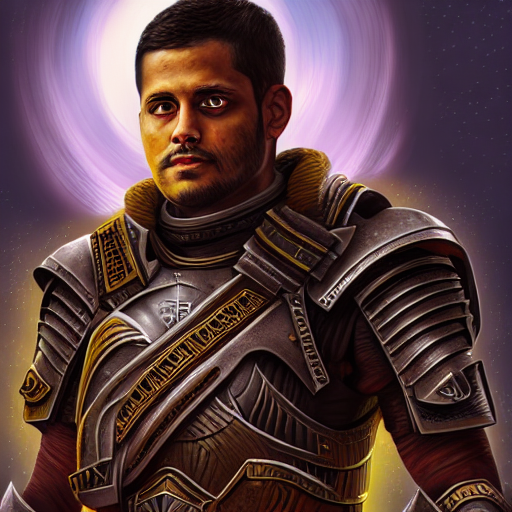

In [ ]:
image = pipeline("A photo of LASR person as a warrior, very detailed, by greg rutkowsky, sci-fi background", guidance_scale=13, num_inference_steps=50).images[0]
image

More training!

In [ ]:
# # 1.000 steps, 100 class images

! accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="Folder" \
  --output_dir="models/my_lora_prior_1000steps/" \
  --instance_prompt="a photo of LASR person" \
  --resolution=512 \
  --max_train_steps=1000 \
  --checkpointing_steps=300 \
  --mixed_precision="fp16" \
  --dataloader_num_workers=8 \
  --train_batch_size=3 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=100 \
  --lr_warmup=0 \
  --num_train_epochs=1 \
  --seed=1234 \
  --prior_loss_weight=1.0 \
  --use_8bit_adam \
  --train_text_encoder \
  --with_prior_preservation \
  --num_class_images=100 \
  --class_data_dir="REGULARIZATION-IMAGES-SD/person" \
  --class_prompt="photo of a person"

2024-03-30 15:04:36.498102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 15:04:36.498159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 15:04:36.499826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 15:04:37.691353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
03/30/2024 15:04:38 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer/tokenizer_config.json: 100% 806/806 [00:00<00:00, 4.17MB/s]
toke

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights("models/my_lora_prior_1000steps/", weight_name="pytorch_lora_weights.safetensors")
#pipeline.scheduler=EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-1.5", subfolder="scheduler")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

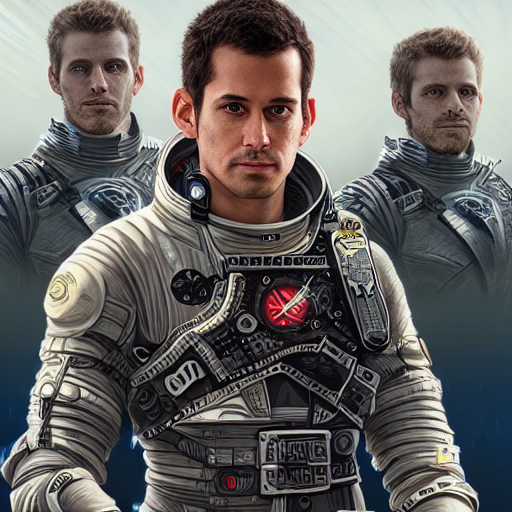

In [ ]:
image = pipeline("A portrait of LASR as space technological punk warrior, in 2024, HD very detailed, by greg rutkowsky", guidance_scale=7, num_inference_steps=50).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

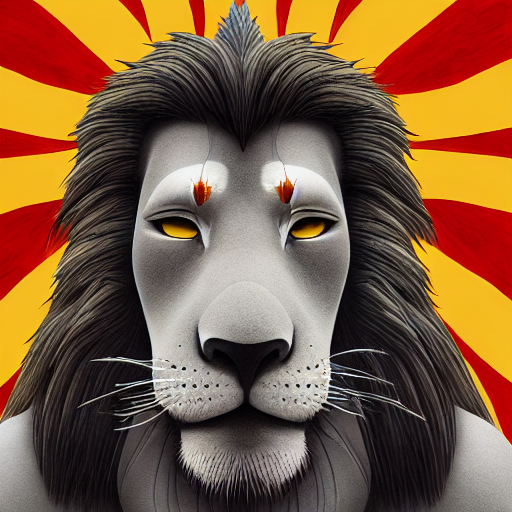

In [ ]:
image = pipeline("LASR as king lion, HD very detailed, by greg rutkowsky", guidance_scale=7, num_inference_steps=50).images[0]
image

---

`Exercise`: Try to find out which **scheduler** works best as you have learned in the previous lab.

`Exercise`: Investigate how to train your model using different techniques.

---

# Training SDXL with Dreambooth and LoRA

In the Huggingface diffusers library repository you can find other ways to train the models.

For example, this is the script to train the SDXL model:


In [ ]:
! wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-03-31 18:40:08--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84322 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.35K  --.-KB/s    in 0.009s  

2024-03-31 18:40:08 (9.28 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84322/84322]



**Note:**
The first thing this code does is download the +10GB model. Then a looooooong training session will begin that can last a long time (+1 hour)... be patient! :)

In [ ]:
! accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="Folder" \
  --output_dir="my_lora_xl_model" \
  --mixed_precision="fp16" \
  --instance_prompt="LASR person" \
  --resolution=1024 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed=1234

# --enable_xformers_memory_efficient_attention \

2024-03-31 18:40:42.142260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 18:40:42.142316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 18:40:42.143496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 18:40:43.152752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
03/31/2024 18:40:44 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer/tokenizer_config.json: 100% 737/737 [00:00<00:00, 3.05MB/s]
toke

Prepare Inference Pipeline

In [ ]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True
).to("cuda")

pipe.load_lora_weights("my_lora_xl_model")

Add scheduler

In [ ]:
pipe.scheduler=EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler")

Execute it!

In [ ]:
image = pipe("A portrait of LASR as space adventurer, very detailed, ultradefined", guidance_scale=7.5, num_inference_steps=50).images[0]
image

---

#### Training Dreambooth but not using LoRA. Train all the weights of the StableDiffusion model

¡There are even other ways to train the model! For example, this is the way to "pure dreambooth training", that is, training all the weights of the Stable Diffusion model.

In [ ]:
! wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py

---